In [2]:
# ПОДКЛЮЧАЕМ БИБЛИОТЕКИ 

import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
from dotenv import load_dotenv
from pathlib import Path

In [3]:
# ДОБАВЛЯЕМ ПЕРЕМЕННЫЕ ОКРУЖЕНИЯ

load_dotenv(dotenv_path='.env', encoding='utf-8-sig')

API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

print(f"API_URL: {API_URL}")
print(f"DATE_BEGIN: {DATE_BEGIN}")
print(f"DATE_END: {DATE_END}")

API_URL: https://data-charts-api.hexlet.app
DATE_BEGIN: 2023-03-01
DATE_END: 2023-09-01


In [4]:
# Создаем папку charts в текущей директории

charts_dir = Path.cwd() / 'charts'
charts_dir.mkdir(exist_ok=True)

print(f"Папка создана/проверена: {charts_dir}")

Папка создана/проверена: c:\projects\data-analytics-project-100\charts


In [5]:
# ФУНКЦИЯ ДЛЯ ПОЛУЧЕНИЯ ДАННЫХ ИЗ API

def get_api_data(endpoint, start_date, end_date, base_url="https://data-charts-api.hexlet.app"):

    url = f"{base_url}/{endpoint}?begin={start_date}&end={end_date}"
    print(f"Запрос: {endpoint} ({start_date} - {end_date})")
    
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        
        df = pd.DataFrame(response.json())
        
        if df.empty:
            print(f"Внимание: Данные для {endpoint} пустые")
            return df
            
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            print(f"Успешно: {endpoint}: {len(df)} записей, период: {df['datetime'].min().date()} - {df['datetime'].max().date()}")
        
        return df
        
    except requests.exceptions.Timeout:
        print(f"Таймаут при запросе {endpoint}")
        return None
    except requests.exceptions.HTTPError as e:
        print(f"HTTP ошибка {e.response.status_code} для {endpoint}")
        return None
    except Exception as e:
        print(f"Ошибка при запросе {endpoint}: {e}")
        return None

# Запрос данных за 6 месяцев
START_DATE = '2023-03-01'
END_DATE = '2023-09-01'

print(f"\nЗагрузка данных за период {START_DATE} - {END_DATE}")
print("=" * 50)

visits_df = get_api_data('visits', START_DATE, END_DATE)
registrations_df = get_api_data('registrations', START_DATE, END_DATE)

# Вывод данных
if visits_df is not None and not visits_df.empty:
    print(f"\nСтатистика визитов:")
    print(f"Всего записей: {len(visits_df)}")
    print("Распределение по платформам:")
    print(visits_df['platform'].value_counts())
    
    bot_visits = visits_df[visits_df['platform'] == 'bot']
    human_visits = visits_df[visits_df['platform'] != 'bot']
    print(f"\nВизиты ботов: {len(bot_visits)} ({len(bot_visits)/len(visits_df)*100:.1f}%)")
    print(f"Визиты людей: {len(human_visits)} ({len(human_visits)/len(visits_df)*100:.1f}%)")

if registrations_df is not None and not registrations_df.empty:
    print(f"\nСтатистика регистраций:")
    print(f"Всего записей: {len(registrations_df)}")
    print("Распределение по платформам:")
    print(registrations_df['platform'].value_counts())
    print("\nТипы регистраций:")
    print(registrations_df['registration_type'].value_counts())


Загрузка данных за период 2023-03-01 - 2023-09-01
Запрос: visits (2023-03-01 - 2023-09-01)
Успешно: visits: 263459 записей, период: 2023-03-01 - 2023-08-31
Запрос: registrations (2023-03-01 - 2023-09-01)
Успешно: registrations: 21836 записей, период: 2023-03-01 - 2023-08-31

Статистика визитов:
Всего записей: 263459
Распределение по платформам:
platform
web        236301
android     13972
bot          7382
ios          5804
Name: count, dtype: int64

Визиты ботов: 7382 (2.8%)
Визиты людей: 256077 (97.2%)

Статистика регистраций:
Всего записей: 21836
Распределение по платформам:
platform
android    10582
web         6877
ios         4377
Name: count, dtype: int64

Типы регистраций:
registration_type
email     8996
google    7105
apple     4006
yandex    1729
Name: count, dtype: int64


In [7]:
# ОБРАБОТКА ВИЗИТОВ

if visits_df is not None and not visits_df.empty:
    
    # Фильтрация ботов
    human_visits = visits_df[~visits_df['user_agent'].str.contains('bot', case=False, na=False)]
    
    # Последний визит каждого пользователя
    last_visits = human_visits.sort_values('datetime').drop_duplicates('visit_id', keep='last')
    
    # Подготовка для группировки
    last_visits['date_group'] = last_visits['datetime'].dt.date
    filtered_visits = last_visits[last_visits['platform'].isin(['web', 'ios', 'android'])]
    
    # Группировка по дате и платформе
    visits_grouped = filtered_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    
    # Сортировка
    visits_grouped = visits_grouped.sort_values(['date_group', 'platform'])
    
    # Вывод данных
    print("Группированные визиты:")
    print(visits_grouped.head(20))
    print(f"\nВсего групп: {len(visits_grouped)}")

Группированные визиты:
    date_group platform  visits
0   2023-03-01  android      75
1   2023-03-01      ios      22
2   2023-03-01      web     279
3   2023-03-02  android      67
4   2023-03-02      ios      31
5   2023-03-02      web     515
6   2023-03-03  android      26
7   2023-03-03      ios      40
8   2023-03-03      web     617
9   2023-03-04  android      94
10  2023-03-04      ios      68
11  2023-03-04      web     485
12  2023-03-05  android      66
13  2023-03-05      ios      16
14  2023-03-05      web     625
15  2023-03-06  android     150
16  2023-03-06      ios      57
17  2023-03-06      web    1084
18  2023-03-07  android      62
19  2023-03-07      ios      25

Всего групп: 552


In [8]:
# ОБРАБОТКА РЕГИСТРАЦИЙ

if registrations_df is not None and not registrations_df.empty:
    
    # Подготовка для группировки
    registrations_df['date_group'] = registrations_df['datetime'].dt.date
    filtered_regs = registrations_df[registrations_df['platform'].isin(['web', 'ios', 'android'])]
    
    # Группировка по дате и платформе
    regs_grouped = filtered_regs.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    
    # Сортировка
    regs_grouped = regs_grouped.sort_values(['date_group', 'platform'])
    
    # Вывод данных
    print("\nГруппированные регистрации:")
    print(regs_grouped.head(20))
    print(f"\nВсего групп: {len(regs_grouped)}")


Группированные регистрации:
    date_group platform  registrations
0   2023-03-01  android             61
1   2023-03-01      ios             18
2   2023-03-01      web              8
3   2023-03-02  android             59
4   2023-03-02      ios             24
5   2023-03-02      web             23
6   2023-03-03  android             22
7   2023-03-03      ios             34
8   2023-03-03      web             51
9   2023-03-04  android             77
10  2023-03-04      ios             43
11  2023-03-04      web             39
12  2023-03-05  android             54
13  2023-03-05      ios             13
14  2023-03-05      web             48
15  2023-03-06  android            109
16  2023-03-06      ios             43
17  2023-03-06      web             78
18  2023-03-07  android             50
19  2023-03-07      ios             19

Всего групп: 552


In [9]:
# ОБЪЕДИНЕНИЕ И РАСЧЕТ КОНВЕРСИИ

if 'visits_grouped' in locals() and 'regs_grouped' in locals():
    # Объединение
    merged_df = pd.merge(visits_grouped, regs_grouped, on=['date_group', 'platform'], how='outer').fillna(0)
    
    # Расчет конверсии
    merged_df['conversion'] = merged_df.apply(
        lambda r: (r['registrations'] / r['visits'] * 100) if r['visits'] > 0 else 0,
        axis=1
    ).round(10)
    
    # Финальная сортировка
    final_df = merged_df.sort_values(['date_group', 'platform']).reset_index(drop=True)
    
    # Сохраняем даты
    final_df['date_group'] = pd.to_datetime(final_df['date_group'])
    
    # Сохранение в JSON
    final_df.to_json('conversion.json', orient='columns', date_format='iso')
    
    # Вывод данных
    print("\nИтоговый датафрейм с конверсией:")
    print(final_df.head(30))
    print(f"\nСохранено в conversion.json")


Итоговый датафрейм с конверсией:
   date_group platform  visits  registrations  conversion
0  2023-03-01  android      75             61   81.333333
1  2023-03-01      ios      22             18   81.818182
2  2023-03-01      web     279              8    2.867384
3  2023-03-02  android      67             59   88.059701
4  2023-03-02      ios      31             24   77.419355
5  2023-03-02      web     515             23    4.466019
6  2023-03-03  android      26             22   84.615385
7  2023-03-03      ios      40             34   85.000000
8  2023-03-03      web     617             51    8.265802
9  2023-03-04  android      94             77   81.914894
10 2023-03-04      ios      68             43   63.235294
11 2023-03-04      web     485             39    8.041237
12 2023-03-05  android      66             54   81.818182
13 2023-03-05      ios      16             13   81.250000
14 2023-03-05      web     625             48    7.680000
15 2023-03-06  android     150        

In [10]:
# ПОДРОБНЫЙ РАСЧЕТ КОНВЕРСИЙ

if 'visits_grouped' in locals() and 'regs_grouped' in locals():
    print("КОНВЕРСИЯ ПО ПЛАТФОРМАМ:")
    print("-" * 50)
    
    # Суммируем по платформам
    visits_sum = visits_grouped.groupby('platform')['visits'].sum()
    regs_sum = regs_grouped.groupby('platform')['registrations'].sum()
    
    # Расчет для каждой платформы
    for platform in ['android', 'ios', 'web']:
        visits = visits_sum.get(platform, 0)
        regs = regs_sum.get(platform, 0)
        if visits > 0:
            conv = (regs / visits) * 100
            print(f"{platform}: {conv:.2f}% (визиты: {visits}, регистрации: {regs})")
    
    # Общая конверсия
    total_v = visits_sum.sum()
    total_r = regs_sum.sum()
    if total_v > 0:
        total_conv = (total_r / total_v) * 100
        print(f"\nСРЕДНЯЯ КОНВЕРСИЯ: {total_conv:.2f}%")
        print(f"Всего: визиты={total_v}, регистрации={total_r}")

КОНВЕРСИЯ ПО ПЛАТФОРМАМ:
--------------------------------------------------
android: 75.74% (визиты: 13972, регистрации: 10582)
ios: 75.41% (визиты: 5804, регистрации: 4377)
web: 5.78% (визиты: 118927, регистрации: 6877)

СРЕДНЯЯ КОНВЕРСИЯ: 15.74%
Всего: визиты=138703, регистрации=21836


In [11]:
# ДОБАВЛЯЕМ ДАННЫЕ ПО РЕКЛАМНЫМ КОМПАНИЯМ

ads_df = pd.read_csv('ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['date_group'] = ads_df['date'].dt.date
ads_grouped = ads_df.groupby('date_group').agg({'utm_campaign': 'first', 'cost': 'sum'}).reset_index()

# Готовим конверсии
final_df['date_group'] = pd.to_datetime(final_df['date_group'], unit='ms').dt.date
conversions_by_date = final_df.groupby('date_group').agg({'visits': 'sum', 'registrations': 'sum'}).reset_index()

# Объединяем
ads_final = pd.merge(conversions_by_date, ads_grouped, on='date_group', how='left')
ads_final['utm_campaign'] = ads_final['utm_campaign'].fillna('none')
ads_final['cost'] = ads_final['cost'].fillna(0).astype(int)
ads_final = ads_final.sort_values('date_group')

# Сохраняем
ads_final['date_group'] = ads_final['date_group'].astype(str)
ads_final.to_json('ads.json', orient='records')

# Выводим
print("ads.json сохранен")
print(ads_final.head())

ads.json сохранен
   date_group  visits  registrations                utm_campaign  cost
0  2023-03-01     376             87  advanced_algorithms_series   212
1  2023-03-02     613            106  advanced_algorithms_series   252
2  2023-03-03     683            107  advanced_algorithms_series   202
3  2023-03-04     647            159  advanced_algorithms_series   223
4  2023-03-05     707            115  advanced_algorithms_series   265


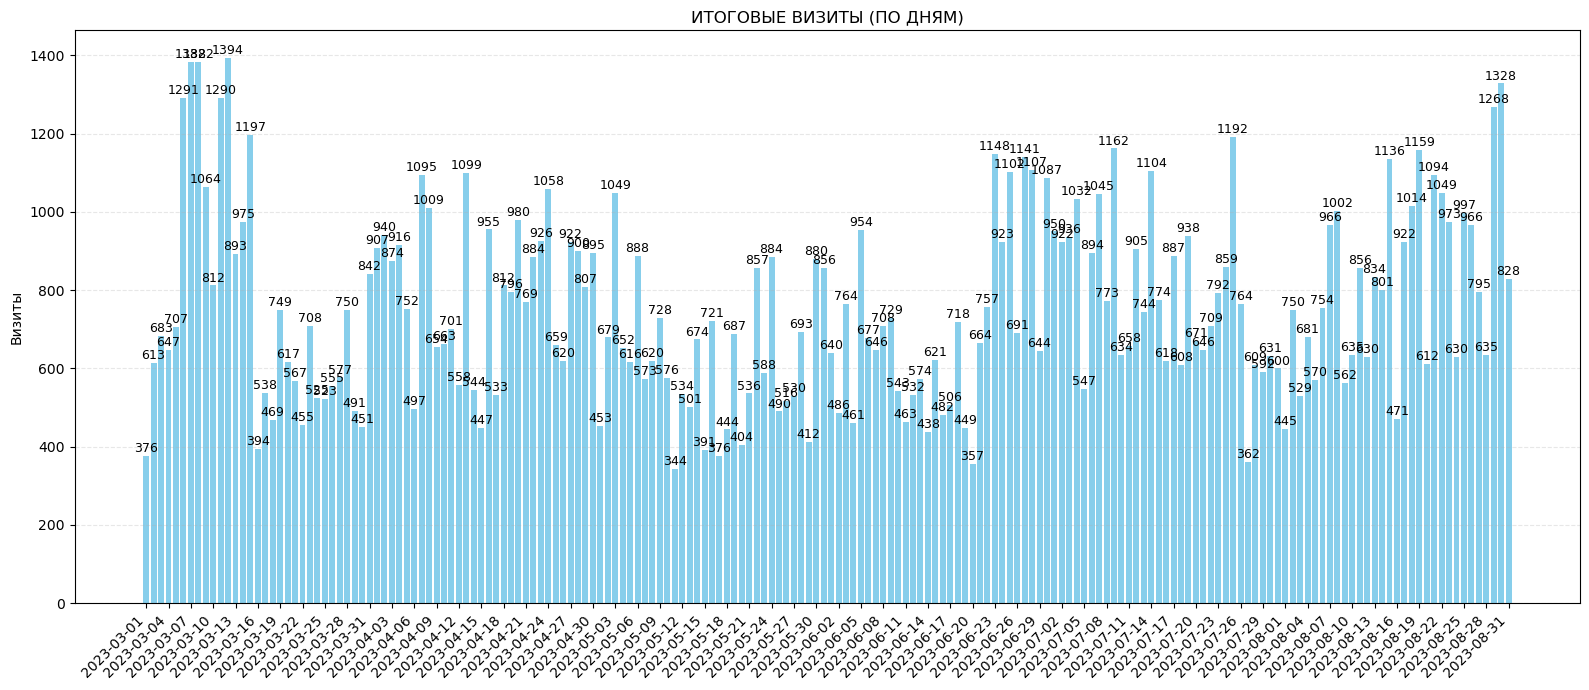

In [12]:
# ГРАФИК ИТОГОВЫХ ВИЗИТОВ

plt.figure(figsize=(16, 7))

# Преобразуем даты
ads_final['date_group_dt'] = pd.to_datetime(ads_final['date_group'])
dates_formatted = ads_final['date_group_dt'].dt.strftime('%Y-%m-%d')

# Строим столбчатую диаграмму
bars = plt.bar(range(len(ads_final)), ads_final['visits'], color='skyblue')

# Добавляем значения над столбцами
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 10,
             f'{int(bar.get_height())}', ha='center', fontsize=9)

plt.title('ИТОГОВЫЕ ВИЗИТЫ (ПО ДНЯМ)')
plt.ylabel('Визиты')

step = 3
xticks_positions = list(range(0, len(ads_final), step))
xticks_labels = [dates_formatted[i] for i in xticks_positions]

plt.xticks(xticks_positions, xticks_labels, rotation=45, ha='right')

# Добавляем сетку
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Сохраняем и показываем график
plt.savefig(charts_dir / 'total_visits.png', dpi=300, bbox_inches='tight')
plt.show()

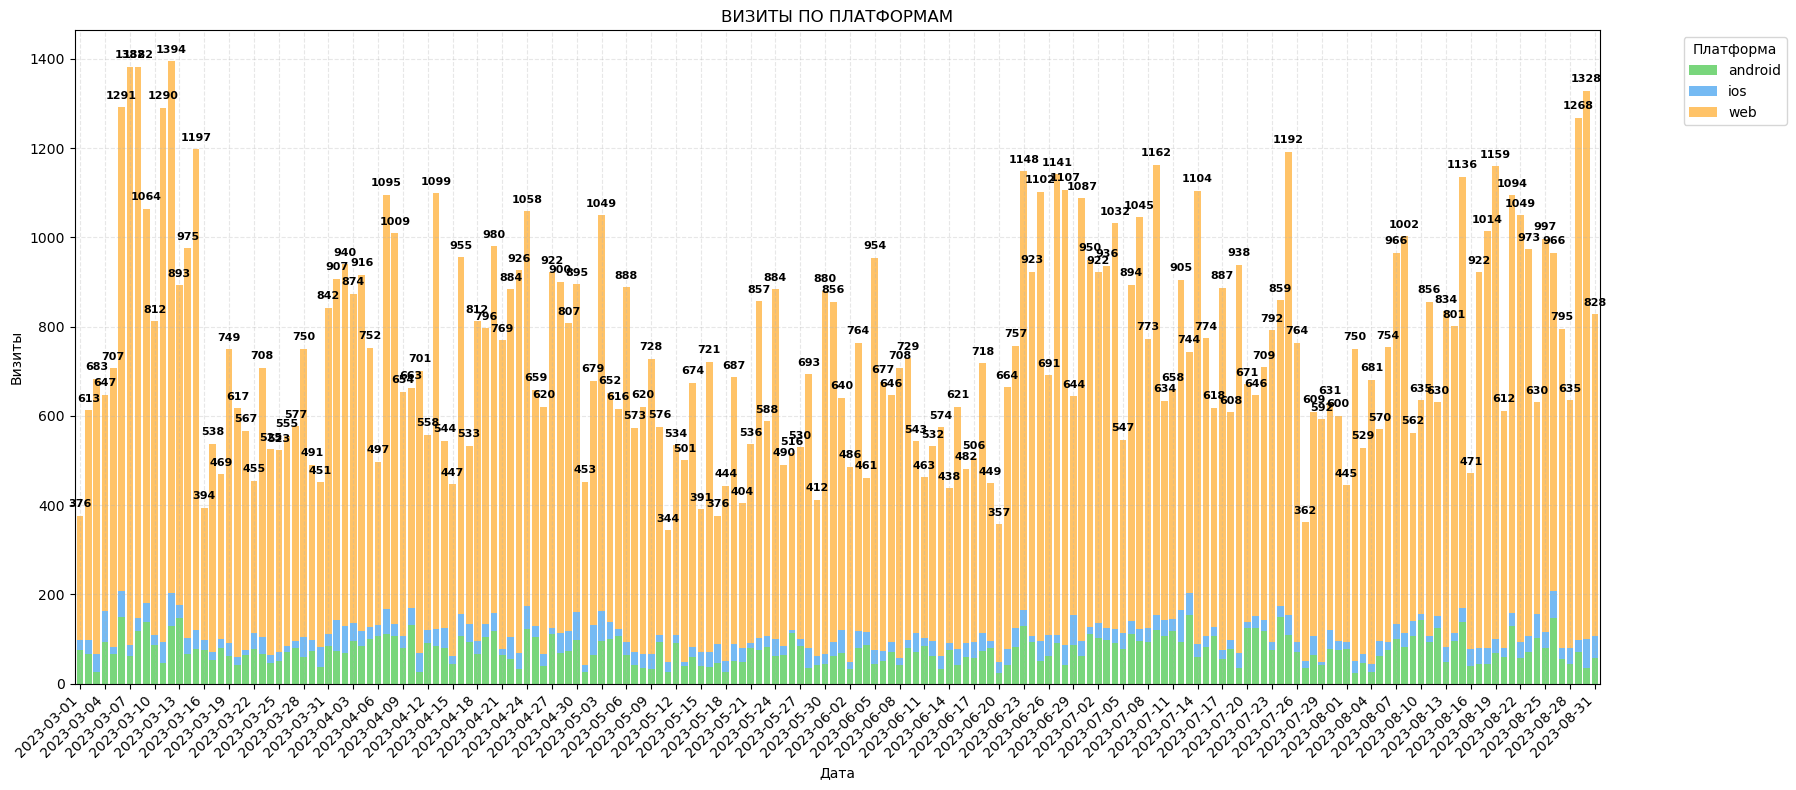

In [13]:
# ГРАФИК ВИЗИТОВ ПО ПЛАТФОРМАМ

fig, ax = plt.subplots(figsize=(18, 8))

# Преобразуем данные
visits_pivot = visits_grouped.pivot(index='date_group', columns='platform', values='visits').fillna(0)
visits_pivot.index = pd.to_datetime(visits_pivot.index)
visits_pivot = visits_pivot.sort_index()

# Строим столбчатую диаграмму
bars = visits_pivot[['android', 'ios', 'web']].plot(kind='bar', stacked=True,
                                                   color=["#79D67C", "#75BAF3", "#FFC368"],
                                                   ax=ax, width=0.8)

ax.set_title('ВИЗИТЫ ПО ПЛАТФОРМАМ')
ax.set_ylabel('Визиты')
ax.set_xlabel('Дата')

step = 3
dates_count = len(visits_pivot)
xticks_positions = list(range(0, dates_count, step))
xticks_labels = [visits_pivot.index[i].strftime('%Y-%m-%d') for i in xticks_positions]

ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, rotation=45, ha='right')

ax.legend(title='Платформа', bbox_to_anchor=(1.05, 1))
plt.grid(True, axis='both', alpha=0.3, linestyle='--')

# Добавляем подписи
for i, (index, row) in enumerate(visits_pivot.iterrows()):
    total_visits = row.sum()
    
    ax.text(
        x=i,
        y=total_visits + (ax.get_ylim()[1] * 0.01),
        s=f'{int(total_visits)}',
        ha='center',
        va='bottom',
        fontsize=8,
        color='black',
        fontweight='bold'
    )

fig.tight_layout()

# Сохраняем и показываем график
plt.savefig(charts_dir / 'total_visits_by_platform.png', dpi=300, bbox_inches='tight')
plt.show()

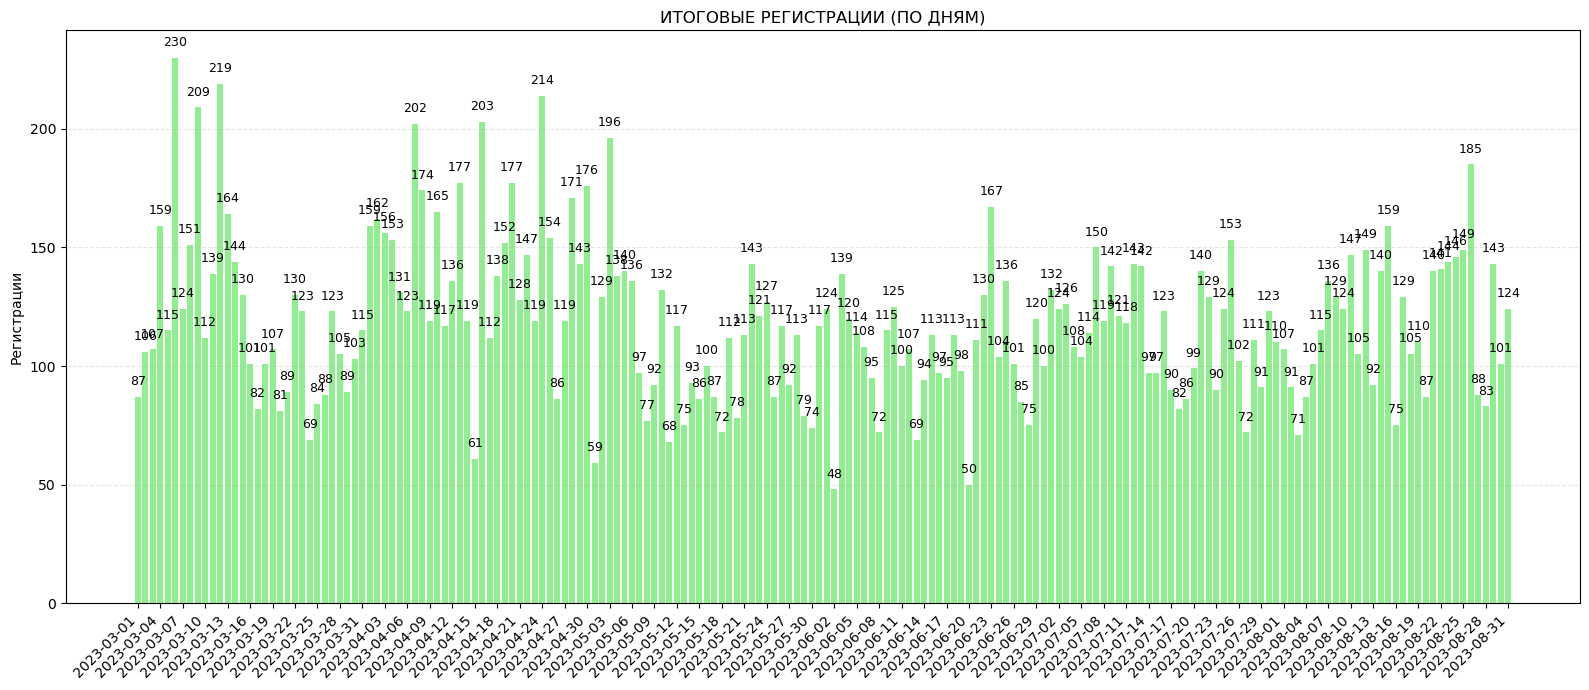

In [14]:
# ГРАФИК ИТОГОВЫХ РЕГИСТРАЦИЙ

plt.figure(figsize=(16, 7))

# Преобразуем даты
ads_final['date_group_dt'] = pd.to_datetime(ads_final['date_group'])
dates_formatted = ads_final['date_group_dt'].dt.strftime('%Y-%m-%d')

# Строим столбчатую диаграмму
bars = plt.bar(range(len(ads_final)), ads_final['registrations'], color='lightgreen')

# Добавляем значения над столбцами
for bar in bars: 
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', fontsize=9)

plt.title('ИТОГОВЫЕ РЕГИСТРАЦИИ (ПО ДНЯМ)')
plt.ylabel('Регистрации')

step = 3
xticks_positions = list(range(0, len(ads_final), step))
xticks_labels = [dates_formatted[i] for i in xticks_positions]

plt.xticks(xticks_positions, xticks_labels, rotation=45, ha='right')

# Добавляем сетку
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Сохраняем и показываем график
plt.savefig(charts_dir / 'total_registrations.png', dpi=300, bbox_inches='tight')
plt.show()

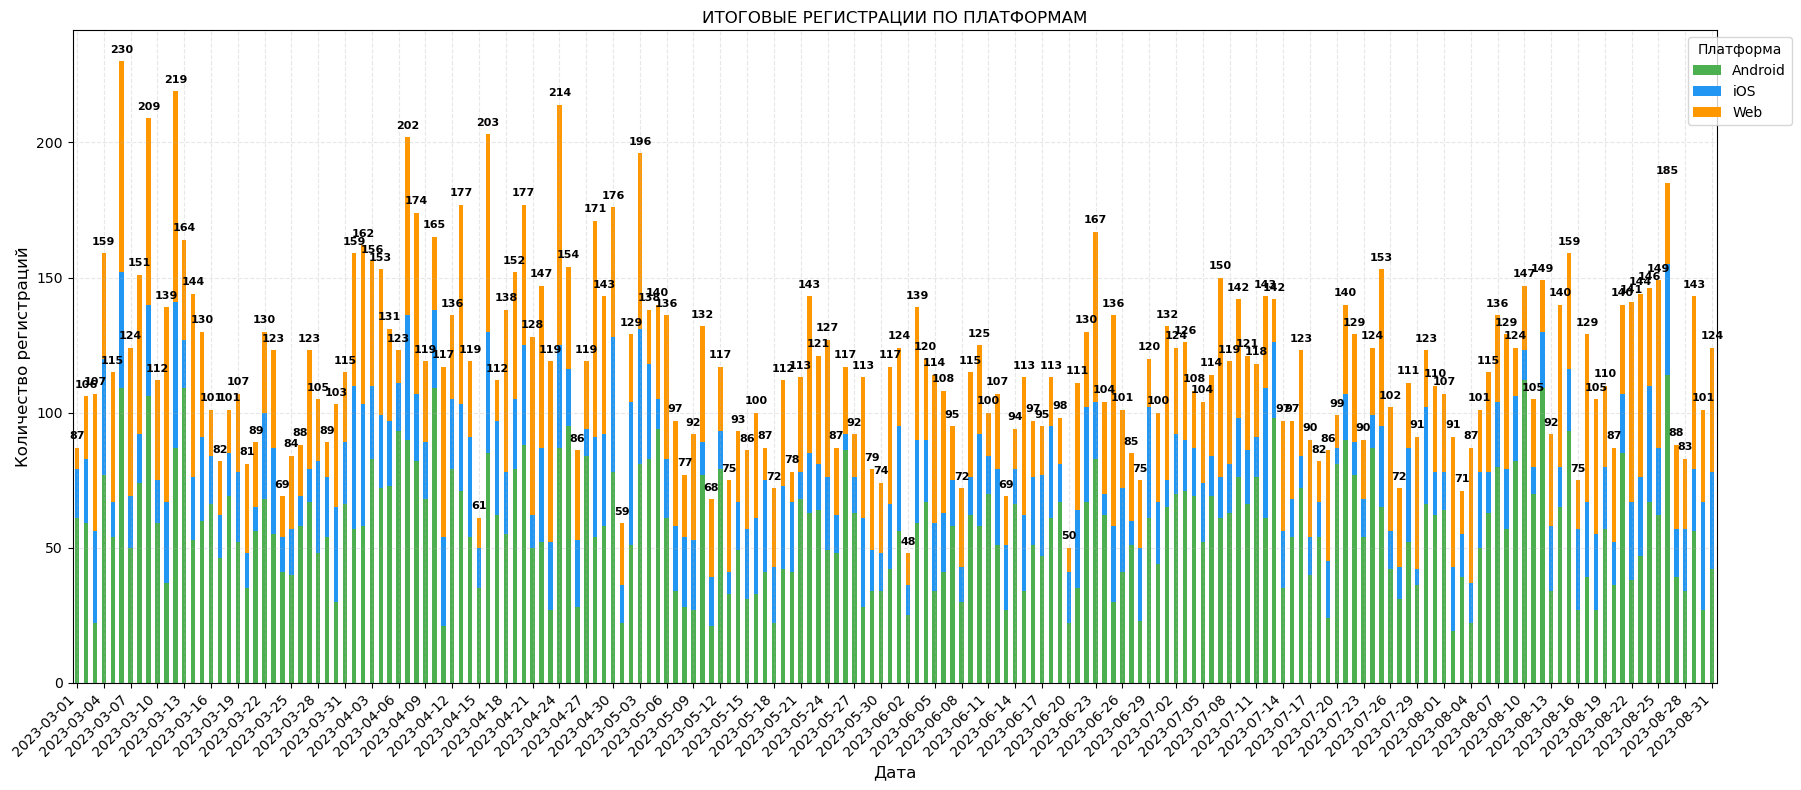

In [15]:
# ГРАФИК РЕГИСТРАЦИЙ ПО ПЛАТФОРМАМ
fig, ax = plt.subplots(figsize=(18, 8))

# Преобразуем данные
regs_pivot = regs_grouped.pivot(index='date_group', columns='platform', values='registrations').fillna(0)
regs_pivot.index = pd.to_datetime(regs_pivot.index)

# Строим график
regs_pivot[['android', 'ios', 'web']].plot(kind='bar', stacked=True,
                                          color=['#4CAF50', '#2196F3', '#FF9800'], ax=ax)

step = 3
xticks = range(0, len(regs_pivot), step)
ax.set_xticks(xticks)
ax.set_xticklabels([regs_pivot.index[i].strftime('%Y-%m-%d') for i in xticks], rotation=45, ha='right')

# Делаем подписи
ax.set_title('ИТОГОВЫЕ РЕГИСТРАЦИИ ПО ПЛАТФОРМАМ')
ax.set_ylabel('Количество регистраций', fontsize=12)
ax.set_xlabel('Дата', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
platform_names = {
    'android': 'Android',
    'ios': 'iOS',
    'web': 'Web'
}
labels = [platform_names.get(label, label) for label in labels]
ax.legend(handles, labels, title='Платформа', bbox_to_anchor=(1.05, 1))

# Добавляем сетку
plt.grid(True, axis='both', alpha=0.3, linestyle='--')

# Добавляем подпсии
for i, (index, row) in enumerate(regs_pivot.iterrows()):
    total_regs = row.sum()
    
    ax.text(
        x=i,
        y=total_regs + (ax.get_ylim()[1] * 0.01),
        s=f'{int(total_regs)}',
        ha='center',
        va='bottom',
        fontsize=8,
        color='black',
        fontweight='bold'
    )

plt.tight_layout()

#Сохраняем и показываем график
output_path = charts_dir / 'total_registrations_by_platform.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)

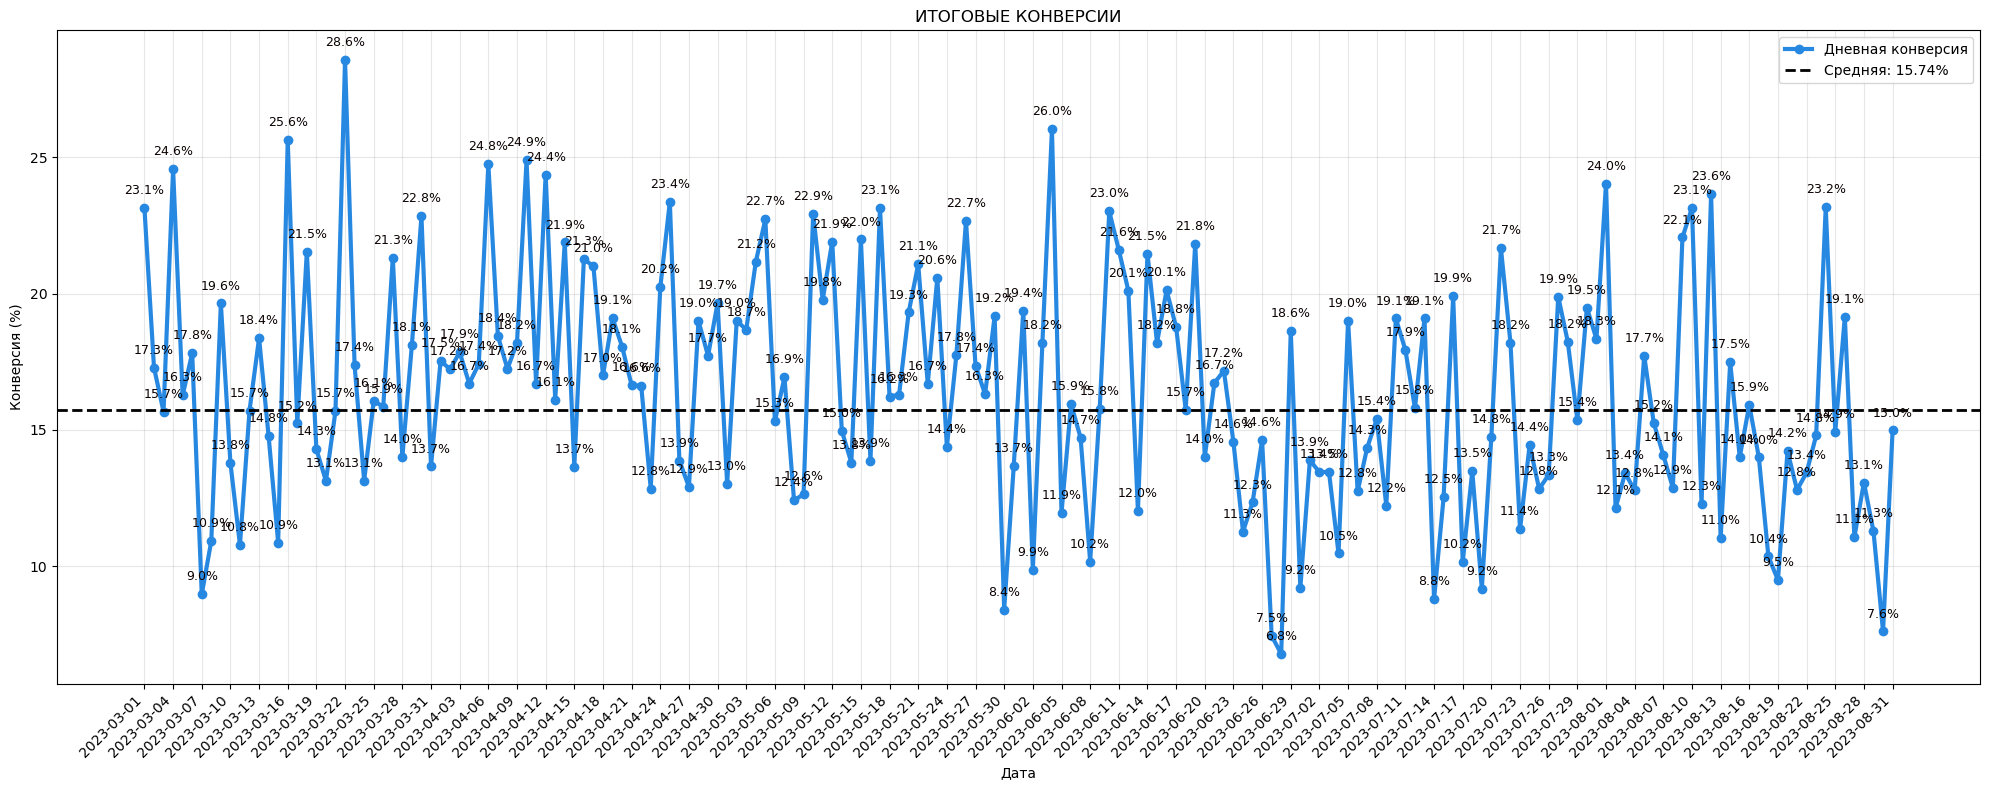

In [16]:
# ГРАФИК ИТОГОВЫХ КОНВЕРСИЙ

fig, ax = plt.subplots(figsize=(20, 8))

# Рассчитываем конверсию
ads_final['conversion'] = (ads_final['registrations'] / ads_final['visits'] * 100).round(2)
ads_final['date_normal'] = pd.to_datetime(ads_final['date_group'])
ads_final = ads_final.sort_values('date_normal')

dates = ads_final['date_normal'].dt.strftime('%Y-%m-%d')
x_pos = range(len(ads_final))

# Строим график
ax.plot(x_pos, ads_final['conversion'], color="#2788E2", linewidth=3, marker='o', markersize=6, label='Дневная конверсия')

for pos, conv in zip(x_pos, ads_final['conversion']):
    ax.annotate(f'{conv:.1f}%', xy=(pos, conv), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=9, color="#0B0101")

# Добавляем среднюю линию
overall_conv = (ads_final['registrations'].sum() / ads_final['visits'].sum() * 100).round(2)
ax.axhline(y=overall_conv, color="#000000", linestyle='--', linewidth=2, label=f'Средняя: {overall_conv}%')

step = 3
xticks = list(range(0, len(ads_final), step))
ax.set_xticks(xticks)
ax.set_xticklabels([dates.iloc[i] for i in xticks], rotation=45, ha='right')

# Добавляем заголовки
ax.set_title('ИТОГОВЫЕ КОНВЕРСИИ')
ax.set_ylabel('Конверсия (%)')
ax.set_xlabel('Дата')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()

#Сохраняем и показываем график
plt.savefig(charts_dir / 'total_conversion.png', dpi=300, bbox_inches='tight')
plt.show()

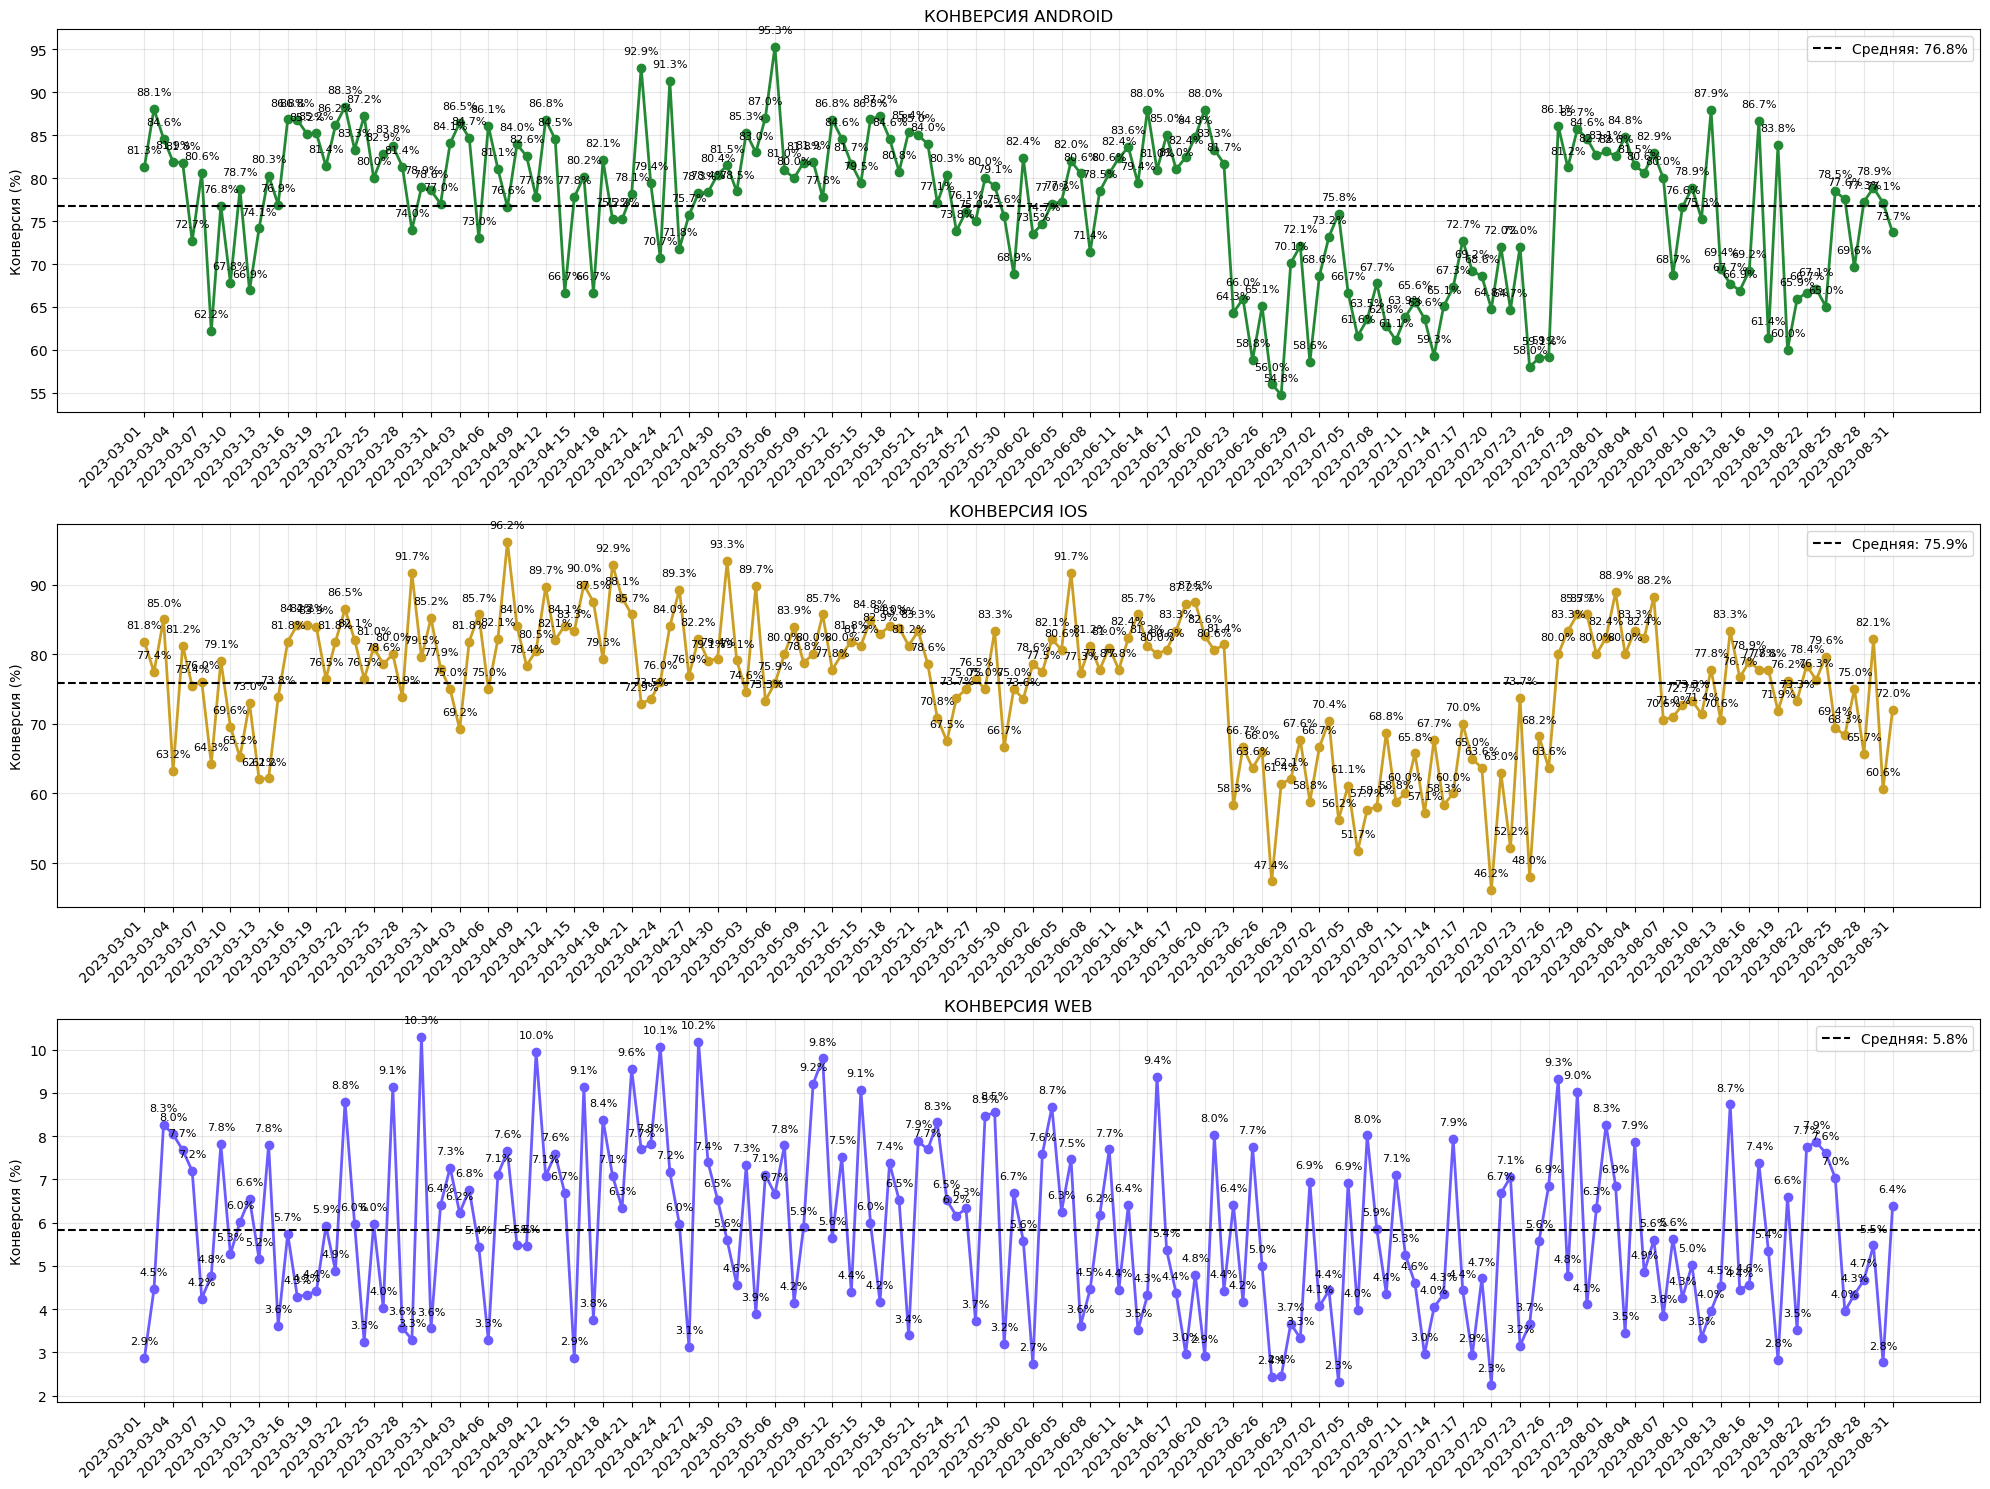

In [17]:
# ГРАФИК КОНВЕРСИЙ ПО ПЛАТФОРМАМ

fig, axes = plt.subplots(3, 1, figsize=(20, 15))
step = 3
platform_data = final_df.copy()
for idx, platform in enumerate(['android', 'ios', 'web']):
    ax = axes[idx]
    platform_df = platform_data.query('platform == @platform').sort_values('date_group')
    platform_df['date_group'] = pd.to_datetime(platform_df['date_group'])
    
    x_positions = range(len(platform_df))
    dates = platform_df['date_group'].dt.strftime('%Y-%m-%d')
    
    ax.plot(x_positions, platform_df['conversion'],
            color=["#238935", "#CB9E24", "#6C5CFF"][idx], linewidth=2, marker='o')
    
    # Подписи точек
    for i, (pos, conv) in enumerate(zip(x_positions, platform_df['conversion'])):
        ax.annotate(f'{conv:.1f}%', xy=(pos, conv), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=8)
    
    # Средняя линия
    ax.axhline(y=platform_df['conversion'].mean(), color='black', linestyle='--',
               label=f'Средняя: {platform_df["conversion"].mean():.1f}%')
    
    # Шаг дат
    xticks = list(range(0, len(platform_df), step))
    ax.set_xticks(xticks)
    ax.set_xticklabels([dates.iloc[i] for i in xticks], rotation=45, ha='right')
    
    ax.set_title(f'КОНВЕРСИЯ {platform.upper()}')
    ax.set_ylabel('Конверсия (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

#Сохраняем и показываем график
plt.savefig(charts_dir / 'total_conversion_by_platform.png', dpi=300, bbox_inches='tight')
plt.show()

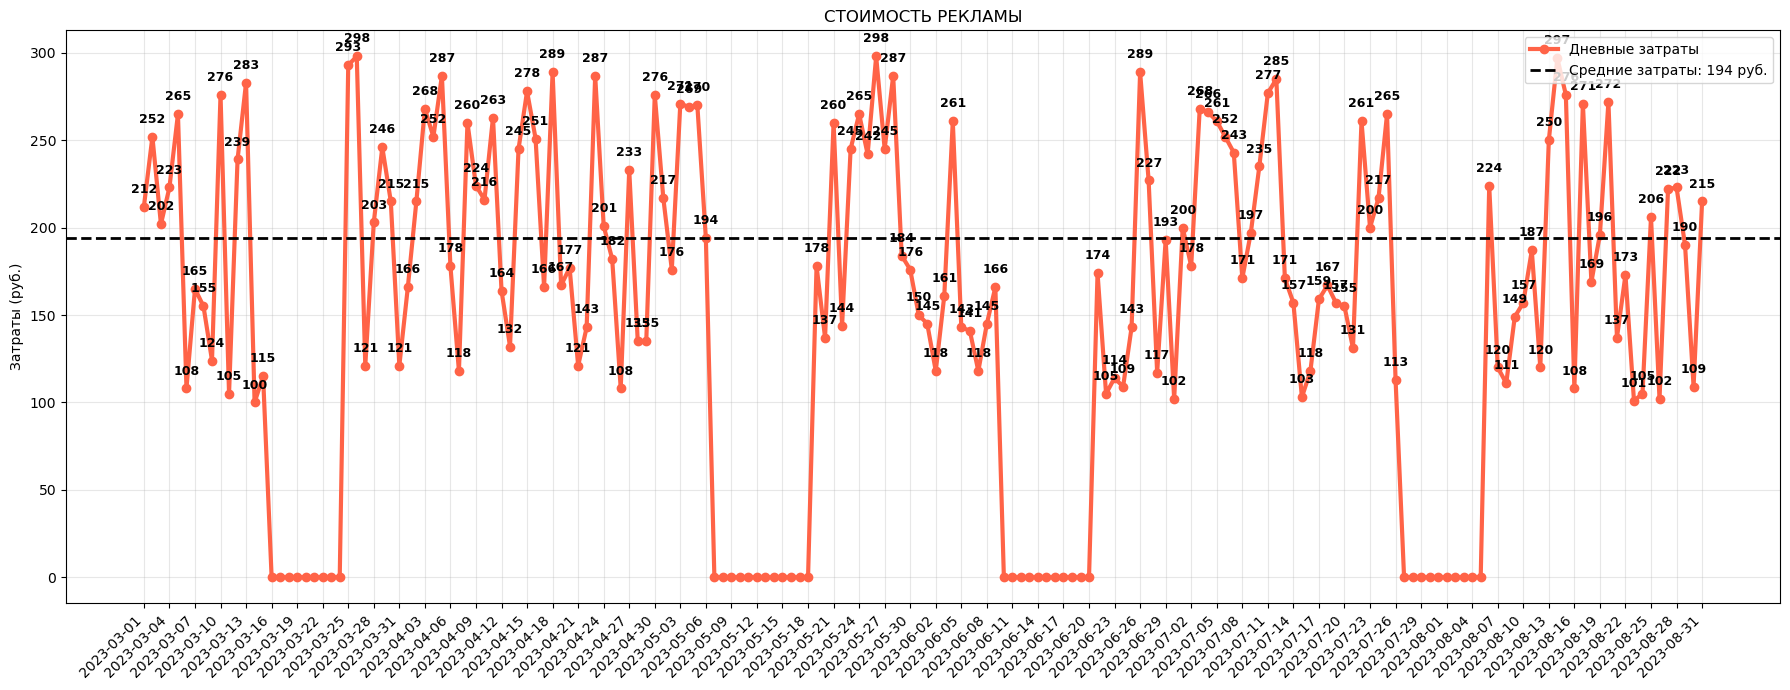

In [19]:
# ГРАФИК СТОИМОСТИ РЕКЛАМЫ

plt.figure(figsize=(18, 7))

# Преобразуем даты
ads_final['date_group_dt'] = pd.to_datetime(ads_final['date_group'])
dates_formatted = ads_final['date_group_dt'].dt.strftime('%Y-%m-%d')
x_positions = range(len(ads_final))

# Строим график
plt.plot(x_positions, ads_final['cost'],
         color='tomato',
         linewidth=3,
         marker='o',
         markersize=6,
         label='Дневные затраты')

# Добавляем подписи
for pos, cost in zip(x_positions, ads_final['cost']):
    if cost > 0:
        plt.annotate(f'{int(cost)}',
                     xy=(pos, cost),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center',
                     fontsize=9,
                     fontweight='bold',
                     color='black')

# Добавляем среднюю линию
days_with_cost = ads_final[ads_final['cost'] > 0]
if len(days_with_cost) > 0:
    avg_cost = days_with_cost['cost'].mean()
    plt.axhline(y=avg_cost, color='black', linestyle='--', linewidth=2,
               label=f'Средние затраты: {avg_cost:.0f} руб.')

# Настраиваем оформление графика
plt.title('СТОИМОСТЬ РЕКЛАМЫ')
plt.ylabel('Затраты (руб.)')

# Устанавливаем шаг
step = 3
xticks_positions = list(range(0, len(ads_final), step))
xticks_labels = [dates_formatted[i] for i in xticks_positions]

plt.xticks(xticks_positions, xticks_labels, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Сохраняем и показываем график
plt.savefig(charts_dir / 'campaigns_cost_by_date.png', dpi=300, bbox_inches='tight')
plt.show()


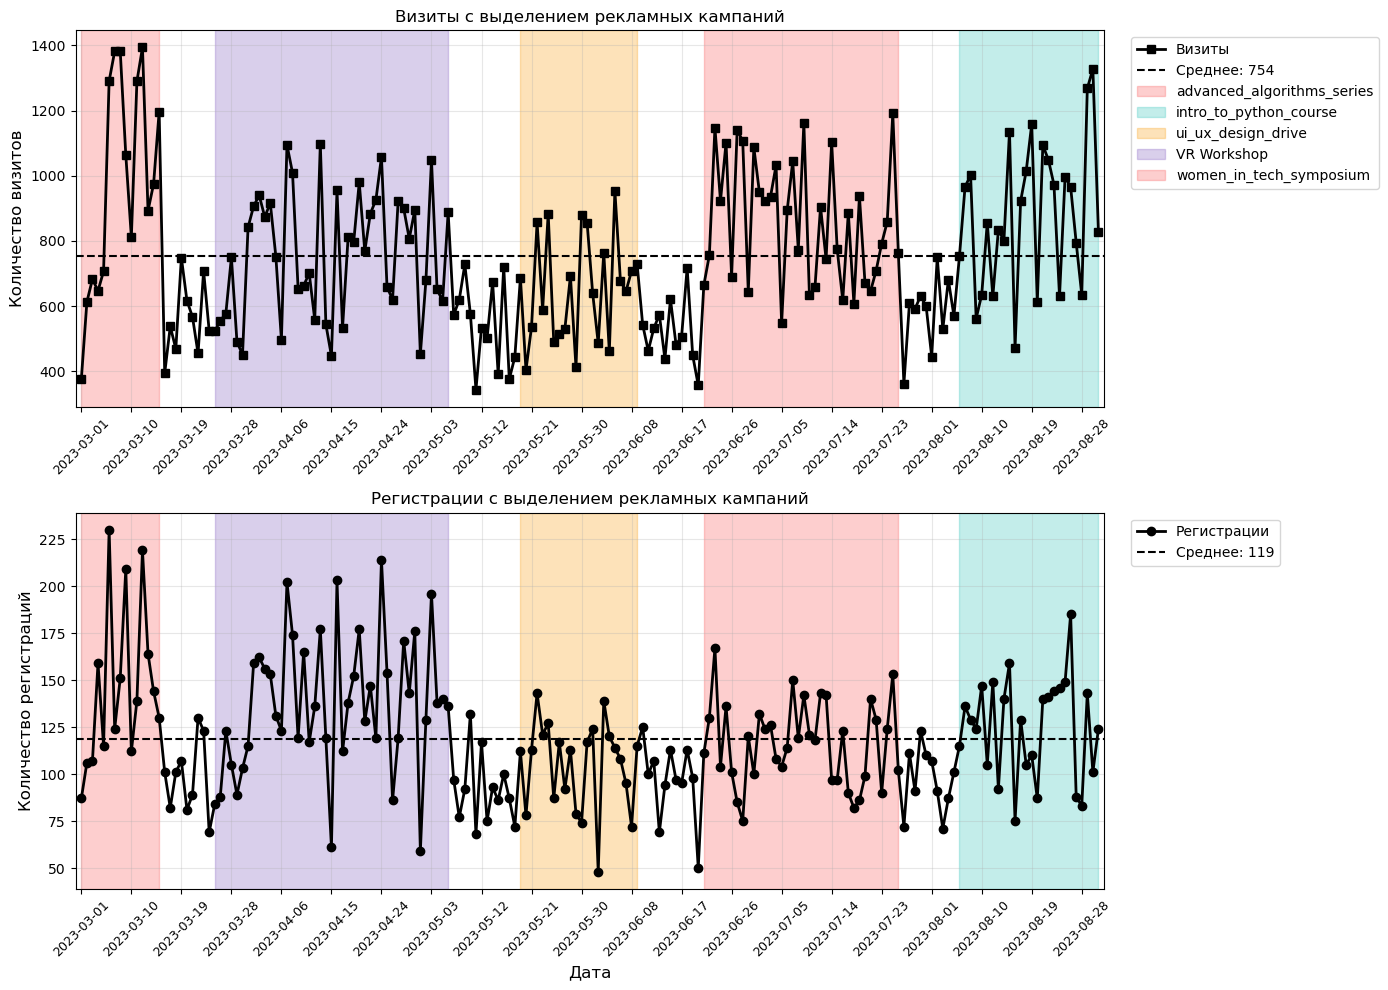

In [20]:
# ДВОЙНОЙ ГРАФИК С РЕКЛАМНЫМИ КАМПАНИЯМИ

ads_final['date_group'] = pd.to_datetime(ads_final['date_group'])

# Сортируем по дате
ads_final = ads_final.sort_values('date_group')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ВЕРХНИЙ ГРАФИК - ВИЗИТЫ
ax1.plot(ads_final['date_group'], ads_final['visits'],
         marker='s', color="#000000", linewidth=2, label='Визиты')
ax1.set_title('Визиты с выделением рекламных кампаний')
ax1.set_ylabel('Количество визитов', fontsize=12)
ax1.grid(True, alpha=0.3)

# Средняя линия для визитов
avg_visits = ads_final['visits'].mean()
ax1.axhline(avg_visits, color='black', linestyle='--',
           label=f'Среднее: {avg_visits:.0f}')  # Округление до целого: :.0f

# НИЖНИЙ ГРАФИК - РЕГИСТРАЦИИ
ax2.plot(ads_final['date_group'], ads_final['registrations'],
         marker='o', color="#000000", linewidth=2, label='Регистрации')
ax2.set_title('Регистрации с выделением рекламных кампаний')
ax2.set_ylabel('Количество регистраций', fontsize=12)
ax2.set_xlabel('Дата', fontsize=12)
ax2.grid(True, alpha=0.3)

# Средняя линия для регистраций
avg_reg = ads_final['registrations'].mean()
ax2.axhline(avg_reg, color='black', linestyle='--',
           label=f'Среднее: {avg_reg:.0f}')

if 'utm_campaign' in ads_final.columns:
    # Фильтруем дни с кампаниями
    campaign_days = ads_final[ads_final['utm_campaign'].notna() &
                             (ads_final['utm_campaign'] != 'none')]
    
    if not campaign_days.empty:
        # Группируем по кампаниям
        campaign_groups = campaign_days.groupby('utm_campaign')
        
        colors = ["#FA5D5D", "#3AC5BC", "#FAA017", "#8461C0"]
        
        # Выделяем каждую кампанию
        for idx, (campaign_name, group) in enumerate(campaign_groups):
            start_date = group['date_group'].min()
            end_date = group['date_group'].max()
            
            if 'virtual_reality' in str(campaign_name).lower():
                label = 'VR Workshop'
            elif 'game_dev' in str(campaign_name).lower():
                label = 'Game Dev Course'
            else:
                label = campaign_name
            
            color = colors[idx % len(colors)]
            ax1.axvspan(start_date, end_date, color=color, alpha=0.3, label=label)
            ax2.axvspan(start_date, end_date, color=color, alpha=0.3)

# Настраиваем даты
num_days = len(ads_final)
interval = max(1, num_days // 20)

locator = mdates.DayLocator(interval=interval)
formatter = mdates.DateFormatter('%Y-%m-%d')

# Для верхнего графика
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.tick_params(axis='x', labelbottom=True, rotation=45, labelsize=9)

# Для нижнего графика
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax2.tick_params(axis='x', rotation=45, labelsize=9)


x_min = ads_final['date_group'].min() - pd.Timedelta(days=1)
x_max = ads_final['date_group'].max() + pd.Timedelta(days=1)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

ax1.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1.02, 1))
ax2.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1.02, 1))

plt.tight_layout()

# Сохраняем и показываем
output_path = charts_dir / 'visits_registrations_with_campaigns.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()